In [12]:
# dependencies for file reading
import json
import sys
import itertools
import numpy as np
import os
from scipy import signal
import matplotlib.pyplot as plt
from IPython.display import Audio, display

import librosa # conda install -c conda-forge librosa
import seaborn as sns

# managing parameters
from parammanager import paramManager
#from Tf_record import tfrecordManager

#synthesizer
import synthInterface as mySM       # the base model for all synths, also some utilities 

#### Demo of synth interface using the single pop synth 

Note: MyPop and myPopPatternSynth are both synths that derive from the mySM.MySoundModel class (and thus have the interface for parameter setting/getting as well as the generate() function for creating audio.

Here we load myPop just to see the interface in action. Normally it would only be used by myPopPatternSynth, and not loaded in a notebook or data set generating program. 

In [13]:
from myPop import MyPop   # This is the single-event synth that myPopPatternSynth uses [loading just for viz purposes]
foosynth=MyPop(440, 10)   # can (optionally) set params for a synth when you create an instance

foosynth.setParam('Q', 25) # Can set any synth parameter with setParam()
foosynth.getParam('Q')    # Get a param value. 

25

In [27]:
fmin = foosynth.getParam('f0', "min")  # by default, getParam would get val, but here we ask for its min
print("min val of synth param f0 is {}".format(fmin))

foosynth.setParamNorm('f0', 0)   #setParamNorm uses [0,1] range 
print("now the value of synth param f0 is {}".format(   foosynth.getParam('f0')    ))


min val of synth param f0 is 100
now the value of synth param f0 is 100


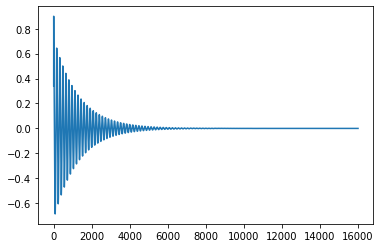

In [28]:
sig=foosynth.generate(1)   # all synths use generate to create audio. Parameter is length in seconds
plt.plot(sig)
display(Audio(sig, rate=16000, autoplay=True))

#### Demo of synth interface using the MyPopPatternSynth

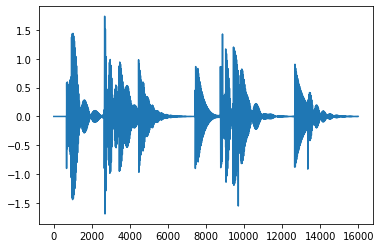

In [33]:
from myPopPatternSynth import MyPopPatternSynth

barsynth=MyPopPatternSynth()
barsynth.setParam("rate_exp", 4) # will make 2^1 events per second
barsynth.setParam("irreg_exp", 1)
barsynth.setParam("Q", 40)

barsig=barsynth.generate(1)      # will generate 3 seconds of sound
plt.plot(barsig)
display(Audio(barsig, rate=16000, autoplay=True))

### Visualize distribution of events

Notice that this code is model-independent (uses only mySM utility function, no synth methods)

number of events is 8000


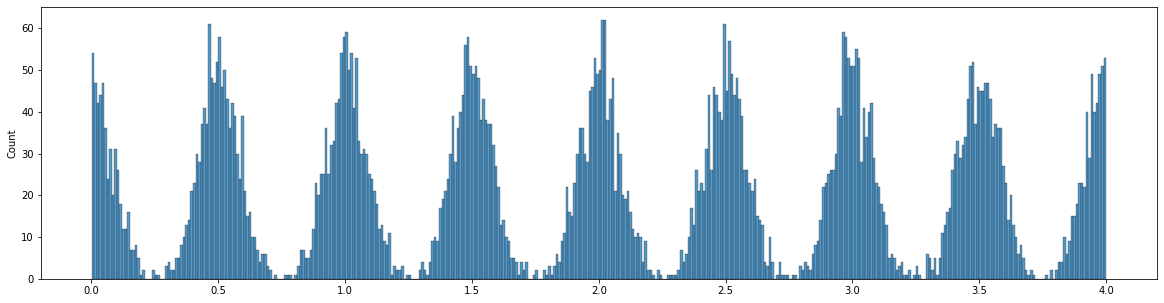

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

events=[]
for i in range(1000) :  #repeat to get enought samples to see the shape of the distribution
                                        #params: (events per second = 2^p1,     sd = .1*p2*10^p2,     seconds)
    events.extend(mySM.noisySpacingTimeList(1, .5, 4))
print("number of events is {}".format(len(events)))
plt.figure(figsize=(20,5))
sns.histplot(events, bins=400)
plt.show()


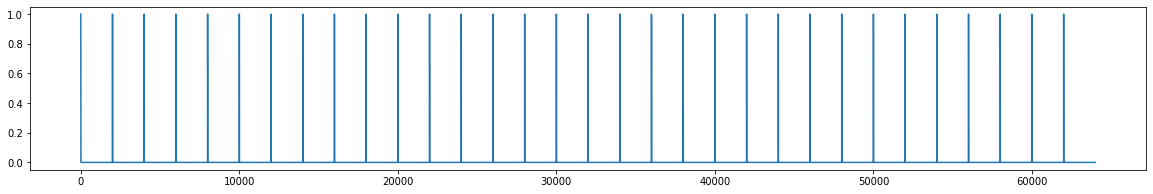

In [25]:
   #params: (events per second = 2^p1,     sd = .1*p2*10^p2,     seconds=p3)
elist = mySM.noisySpacingTimeList(3, 0, 4)
esig = mySM.timeList2Sig(elist,16000,4)

plt.figure(figsize=(20,3))
plt.plot(esig)